Step 1: Understand the Dataset

Train.csv – Contains image IDs and their corresponding labels (0 = not affected, 1 = affected).

Test.csv – Contains image IDs for which you need to predict labels.

SampleSubmission.csv – Shows the expected format for your final submission.

Images.zip – Contains all the image files (likely for both training and test data).

### Step 2: Install Required Packages
Install necessary Python packages.

In [30]:
!pip install opencv-python
!pip install numpy==1.23

### Step 3: Import Libraries
Import all required libraries for data processing, modeling, and visualization.

In [31]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout



### Step 4: Load Training Data
Load the training CSV file which contains image IDs and their corresponding labels.

In [32]:
train_df = pd.read_csv("Data/Train.csv")
print(train_df.columns)  # Fix column case sensitivity


Index(['Image_id', 'Label'], dtype='object')


### Step 5: Preprocess Images
Load and preprocess images from the directory. Resize them and convert to arrays.

In [33]:
image_folder = "Data/Images"
image_size = (128, 128)  # You can change this depending on device limitations

train_images = []
train_labels = []

for i, row in train_df.iterrows():
    image_id = row['Image_id']  # Already has .jpg
    label = row['Label']
    
    image_path = os.path.join(image_folder, image_id)

    if os.path.exists(image_path):
        img = cv2.imread(image_path)
        img = cv2.resize(img, image_size)
        train_images.append(img)
        train_labels.append(label)
    else:
        print(f"Missing image: {image_path}")


### Step 6: Normalize Image Data
Normalize image pixel values for model training.

In [34]:
train_images = np.array(train_images) / 255.0  # Normalize pixel values
train_labels = np.array(train_labels)


### Step 7: Split Data
Split the data into training and validation sets.

In [35]:
X_train, X_val, y_train, y_val = train_test_split(
    train_images, train_labels, test_size=0.2, stratify=train_labels, random_state=42
)


### Step 8: Define the Model
Build a CNN model using Keras Sequential API.

In [36]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(2,2),
    
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])
model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 57600)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               7372928   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)              

### Step 9: Data Augmentation & Training
Apply data augmentation and train the model.

In [37]:
datagen = ImageDataGenerator(horizontal_flip=True, rotation_range=20, zoom_range=0.2)

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_val, y_val),
    epochs=10
)


Epoch 1/10
41/41 [==============================] - 8s 204ms/step - loss: 0.6894 - auc: 0.6372 - val_loss: 0.5802 - val_auc: 0.8528
Epoch 2/10
41/41 [==============================] - 8s 191ms/step - loss: 0.5374 - auc: 0.8094 - val_loss: 0.4143 - val_auc: 0.8963
Epoch 3/10
41/41 [==============================] - 8s 185ms/step - loss: 0.4342 - auc: 0.8849 - val_loss: 0.3669 - val_auc: 0.9158
Epoch 4/10
41/41 [==============================] - 8s 190ms/step - loss: 0.4211 - auc: 0.8939 - val_loss: 0.3555 - val_auc: 0.9223
Epoch 5/10
41/41 [==============================] - 7s 178ms/step - loss: 0.4299 - auc: 0.8870 - val_loss: 0.3125 - val_auc: 0.9399
Epoch 6/10
41/41 [==============================] - 7s 176ms/step - loss: 0.3618 - auc: 0.9207 - val_loss: 0.3449 - val_auc: 0.9508
Epoch 7/10
41/41 [==============================] - 7s 179ms/step - loss: 0.3334 - auc: 0.9339 - val_loss: 0.3837 - val_auc: 0.9534
Epoch 8/10
41/41 [==============================] - 7s 183ms/step - loss: 0.

### Step 10: Evaluate the Model
Evaluate model performance on the validation set.

In [38]:
loss, auc = model.evaluate(X_val, y_val)
print(f"Validation AUC: {auc:.4f}")

model.save("fall_armyworm_cnn.h5")


11/11 [==============================] - 0s 41ms/step - loss: 0.3468 - auc: 0.9443
Validation AUC: 0.9443


### Step 11: Save the Model
Save the trained model for future inference.

In [39]:
model.save('Data/my_model.h5')


### Step 12: Load Test Data and Model
Prepare the environment for testing and load the saved model.

In [40]:
import pandas as pd
import tensorflow as tf
import numpy as np
import os

# Parameters
img_height = 128  # your image size
img_width = 128
batch_size = 32

# Paths
test_csv_path = "Data\Test.csv"
test_images_folder = "Data\Images"  # update if needed

# Load test IDs
test_df = pd.read_csv(test_csv_path)
image_ids = test_df['Image_id'].tolist()  # this column in your Test.csv

def load_and_preprocess_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)  # or decode_png if needed
    img = tf.image.resize(img, [img_height, img_width])
    img = img / 255.0
    return img

# Full image paths
test_image_paths = [os.path.join(test_images_folder, img_id) for img_id in image_ids]

# Dataset
test_ds = tf.data.Dataset.from_tensor_slices(test_image_paths)
test_ds = test_ds.map(load_and_preprocess_image).batch(batch_size)

# Load model
model = tf.keras.models.load_model('Data/my_model.h5')


# Predict
predictions = model.predict(test_ds)

# Prepare submission dataframe with correct columns and formatting
submission_df = pd.DataFrame({
    'Image_ID': image_ids,
    'Target': predictions.flatten()
})

# Save submission file
submission_df.to_csv('submission.csv', index=False)
print("Saved submission.csv with columns ['Image_ID', 'Target']")


Saved submission.csv with columns ['Image_ID', 'Target']


### Step 13: Visualize Predictions
Display prediction results using matplotlib.

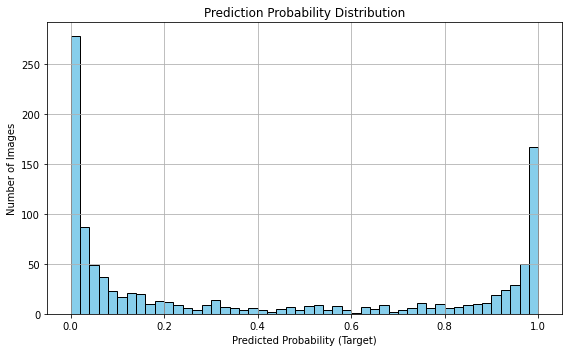

In [44]:
import matplotlib.pyplot as plt

# Assuming 'predictions' is a NumPy array from model.predict(test_ds)
plt.figure(figsize=(8, 5))
plt.hist(predictions.flatten(), bins=50, color='skyblue', edgecolor='black')
plt.title('Prediction Probability Distribution')
plt.xlabel('Predicted Probability (Target)')
plt.ylabel('Number of Images')
plt.grid(True)
plt.tight_layout()
plt.show()

